In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline

## 1. Проверка на нормальность

In [2]:
data = pd.read_csv('data/genetherapy.csv')
for therapy, group in data.groupby('Therapy'):
    print(therapy, ':', stats.kstest(group.expr, 'norm'), ' Shapiro', stats.shapiro(group.expr))

A : KstestResult(statistic=1.0, pvalue=0.0)  Shapiro (0.887749969959259, 0.062011588364839554)
B : KstestResult(statistic=1.0, pvalue=0.0)  Shapiro (0.9259758591651917, 0.23740161955356598)
C : KstestResult(statistic=1.0, pvalue=0.0)  Shapiro (0.9287736415863037, 0.2615790367126465)
D : KstestResult(statistic=1.0, pvalue=0.0)  Shapiro (0.9913022518157959, 0.999784529209137)


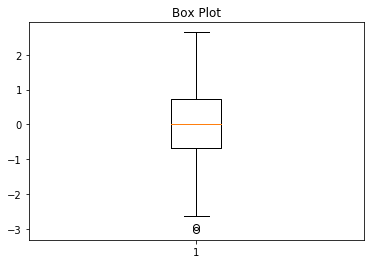

In [29]:
plt.boxplot(np.random.normal(0, 1, 500))
plt.title('Box Plot')
plt.show()

## 2. One-way ANOVA

Сравнивается 4 типа генотерапии и их эффективность:

### 2.1. Используя модуль **scipy.stats**

In [3]:
data = pd.read_csv('data/genetherapy.csv')
A = data[data['Therapy'] == 'A']['expr']
B = data[data['Therapy'] == 'B']['expr']
C = data[data['Therapy'] == 'C']['expr']
D = data[data['Therapy'] == 'D']['expr']
stats.f_oneway(A, B, C, D)

F_onewayResult(statistic=8.03730248114399, pvalue=0.00015249722895229536)

### 2.2 Используя модуль **statsmodels**

In [4]:
res = smf.ols('expr ~ Therapy', data=data).fit()
sm.stats.anova_lm(res, typ=2)
# res.summary()

,sum_sq,df,F,PR(>F)
Therapy,560.716667,3.0,8.037302,0.000152
Residual,1302.266667,56.0,NaN,NaN


### 2.3. Визуализация

means  :  99.73 98.8 94.4 92.33
errors :  2.31 3.25 2.87 2.05


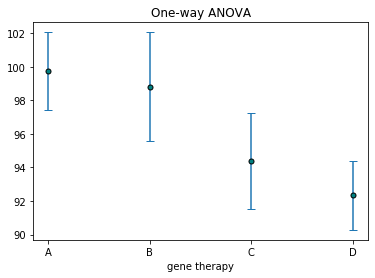

In [5]:
groups = list(pd.unique(data.Therapy.values))
means = data['expr'].groupby(data['Therapy']).mean().round(2)
sterrs = data['expr'].groupby(data['Therapy']).sem().round(2)
errors = (2.14 * sterrs).round(2)
print('means  : ', *means)
print('errors : ', *errors)

plt.errorbar(x=groups, y=means, yerr=errors, capsize=4, fmt='o', markersize=5, mfc='teal', mec='black')
plt.title('One-way ANOVA')
plt.xlabel('gene therapy')
plt.show()

**Вывод**: наличие различия между группами статистически достоверно, однако пока нельзя сделать вывод между какими именно группами оно есть.


### 2.4. Множественные сравнения

In [6]:
res.t_test_pairwise('Therapy', method='bonferroni').result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-bonferroni,reject-bonferroni
B-A,-0.933333,1.760862,-0.530043,0.598177,-4.460764,2.594097,1.000000,False
C-A,-5.333333,1.760862,-3.028820,0.003709,-8.860764,-1.805903,0.022256,True
D-A,-7.400000,1.760862,-4.202487,0.000096,-10.927430,-3.872570,0.000575,True
C-B,-4.400000,1.760862,-2.498776,0.015423,-7.927430,-0.872570,0.092536,False
D-B,-6.466667,1.760862,-3.672444,0.000538,-9.994097,-2.939236,0.003229,True
D-C,-2.066667,1.760862,-1.173668,0.245496,-5.594097,1.460764,1.000000,False


## 3. n-way ANOVA

Изучается влияние инъекции некоторого гормона на концентрацию кальция в плазме крови у птиц с учётом пола:

In [7]:
data = pd.read_csv('data/birds.csv')
res = smf.ols('var4 ~ hormone + sex + hormone:sex', data=data).fit()
sm.stats.anova_lm(res, typ=2)

,sum_sq,df,F,PR(>F)
hormone,0.847472,1.0,0.086528,0.769653
sex,0.119762,1.0,0.012228,0.912318
hormone:sex,89.483384,1.0,9.136390,0.003682
Residual,587.650394,60.0,NaN,NaN


**Вывод**: получилось, что ни фактор пола, ни фактор гормона по отдельности не оказывают значимого влияния на зависимую переменную, однако их взаимодействие — оказывает.

## 4. Простая линейная регрессия

Изучается связь уровней бедности и образования в штатах США.

### 4.1. С помощью модуля **scipy.stats**

intercept = 64.78   slope   = -0.62
r         = -0.75   p       = 3.10882981031841e-10   std error = 0.079



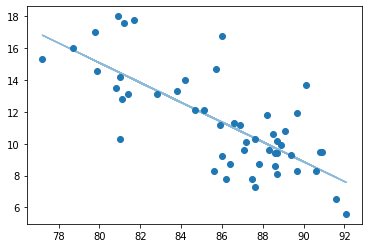

In [9]:
data = pd.read_csv('data/states.csv')
b1, b0, r, p, st_err = stats.linregress(data['hs_grad'], data['poverty'])
print('intercept =', round(b0, 2), '  slope   =', round(b1, 2))
print('r         =', round(r, 2), '  p       =', p, '  std error =', round(st_err, 4), end='\n\n')

plt.scatter(x='hs_grad', y='poverty', data=data)
plt.plot(data['hs_grad'], b0+b1*data['hs_grad'], alpha=0.5)
plt.show()

### 4.2. С помощью модуля **seaborn**

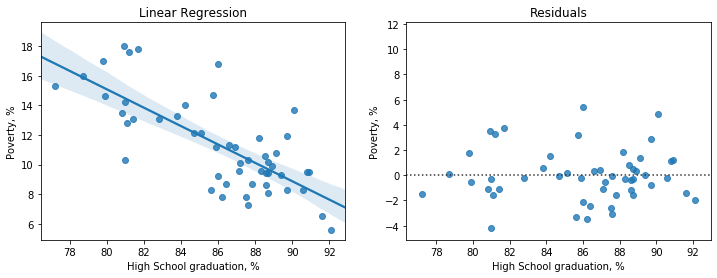

In [10]:
data = pd.read_csv('data/states.csv')
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

sns.regplot(x='hs_grad', y='poverty', data=data, ax=axs[0])
sns.residplot(x='hs_grad', y='poverty', data=data, color='tab:blue', ax=axs[1])

axs[0].set_xlabel('High School graduation, %')
axs[0].set_ylabel('Poverty, %')
axs[0].set_title('Linear Regression')
axs[1].set_xlabel('High School graduation, %')
axs[1].set_ylabel('Poverty, %')
axs[1].set_title('Residuals')
plt.show()

### 4.3. С помощью модуля **statsmodels**

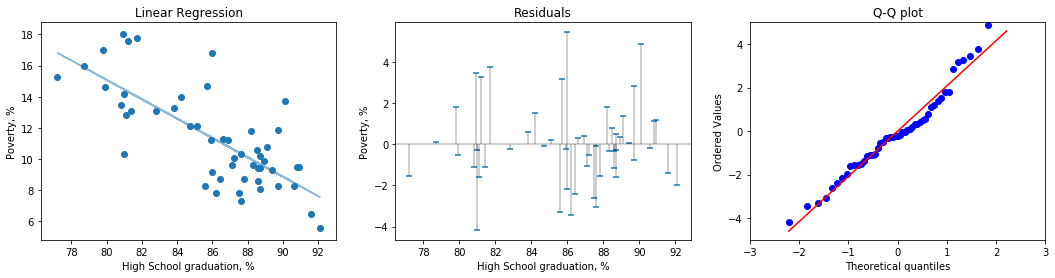

In [12]:
data = pd.read_csv('data/states.csv')
result = smf.ols(formula='poverty ~ hs_grad', data=data).fit()
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))

# 1. Linear regression
axs[0].plot(data['hs_grad'], result.params[0] + data['hs_grad'] * result.params[1], alpha=0.5)
axs[0].scatter(x='hs_grad', y='poverty', data=data)

# 2. Residuals
axs[1].scatter(data['hs_grad'], result.resid, marker='_')
axs[1].vlines(x='hs_grad', ymin=0, ymax=result.resid, alpha=0.25, data=data)
axs[1].axhline(0, color='black', alpha=0.25)

# 3. QQ plot
stats.probplot(result.resid, plot=axs[2])

axs[0].set_xlabel('High School graduation, %')
axs[0].set_ylabel('Poverty, %')
axs[0].set_title('Linear Regression')
axs[1].set_xlabel('High School graduation, %')
axs[1].set_ylabel('Poverty, %')
axs[1].set_title('Residuals')
axs[2].set_title('Q-Q plot')
axs[2].set_xlim([-3, 3])
axs[2].set_ylim([-5, 5])
plt.show()

**Вывод**: получили статистически значимую отрицательную линейную связь.

## 5. Многомерная линейная регрессия

### 5.1. Создание модели

In [13]:
data = pd.read_csv('data/states.csv')
result = smf.ols(formula="poverty ~ metro_res + white + hs_grad + female_house", data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sat, 30 Nov 2019   Prob (F-statistic):           8.88e-10
Time:                        14:49:32   Log-Likelihood:                -103.39
No. Observations:                  51   AIC:                             216.8
Df Residuals:                      46   BIC:                             226.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.4765     12.590      5.280   

**Вывод**: получили статистически значимую связь бедности с факторами образования и населения столичного региона штата.

### 5.2. Модификация модели

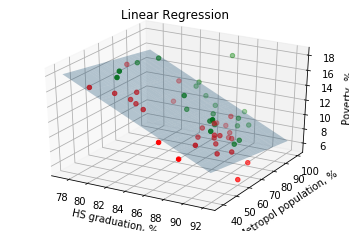

In [15]:
lm = smf.ols(formula='poverty ~ metro_res + hs_grad', data=data).fit()

def f(x, y):
    return lm.params.Intercept + lm.params.hs_grad * x  + lm.params.metro_res * y

x = data.hs_grad.sort_values()
y = data.metro_res.sort_values()
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.3)
data_below_serf = data[data['poverty'] < f(data['hs_grad'], data['metro_res'])]
data_above_serf = data[data['poverty'] >= f(data['hs_grad'], data['metro_res'])]
ax.scatter(data_below_serf.hs_grad, data_below_serf.metro_res, data_below_serf.poverty, c='r', marker='o')
ax.scatter(data_above_serf.hs_grad, data_above_serf.metro_res, data_above_serf.poverty, c='g', marker='o')
ax.set_title('Linear Regression')
ax.set_xlabel('HS graduation, %')
ax.set_ylabel('Metropol population, %')
ax.set_zlabel('Poverty, %')
plt.show()

### 5.3. Проверка переменных на мультиколлинеарность

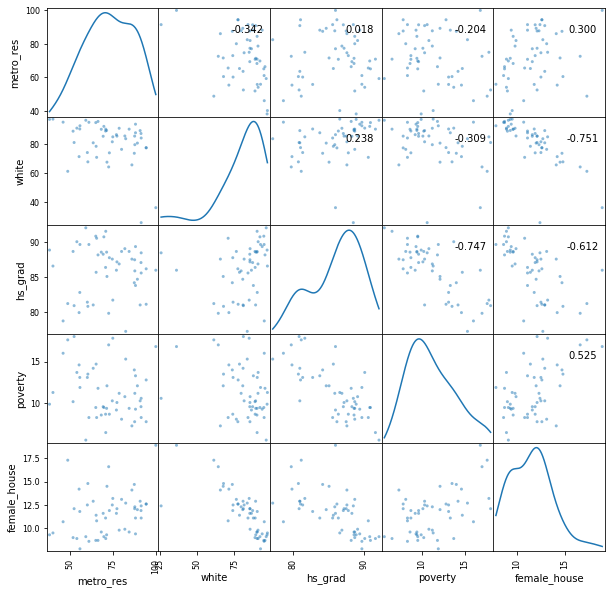

In [19]:
axes = pd.plotting.scatter_matrix(data, figsize=(10,10), diagonal='kde', grid=True)
corr = data.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

# sns.PairGrid(data).map(plt.scatter)

**Вывод**: переменная female_house сильно скоррелирована с другими независимыми, от неё и следует избавится для улучшения модели.

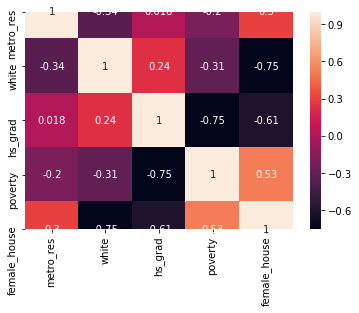

In [18]:
sns.heatmap(data.corr(), cbar=True, annot=True)
plt.show()